In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

results_info = results_gen_info
results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
df = df[df.localization_node != 'localization_generator']
# df = df[df.amcl_alpha_factor == 1.0]

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    10499

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    fixed_rpp                                                              [False, True]

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['turtle']

    run_duplicate_index                                                    [nan, 1.0, 2.0]

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

    beta_1                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_4                                                                 [0.0]

## Metrics

    average_clearance                                                      min:      1.912             avg:      5.033             max:      12.42             nan:          0

    average_rotation_acceleration                                          min:  9.015e-06             avg:     0.1795             max:     0.9988             nan:        710

    average_rotation_velocity                                              min:  0.0006432             avg:     0.1374             max:     0.9651             nan:        710

    average_translation_acceleration                                       min:  6.565e-05             avg:     0.1213             max:     0.3207             nan:        710

    average_translation_velocity                                           min:  0.0008283             avg:     0.2532             max:       0.35             nan:        710

    average_velocity_atan                                                  min:    0.01083             avg:      0.358             max:      1.328             nan:        710

    clearance                                                              min:        nan             avg:        nan             max:        nan             nan:   1.05e+04

    clearance_version                                                      [1.0]

    collision_rate                                                         min:          0             avg:    0.03305             max:          1             nan:          0

    collision_rate_version                                                 [3]

    collision_time                                                         min:       11.1             avg:      105.9             max:      432.1             nan:  1.015e+04

    absolute_rotation_error                                                min:  0.0001497             avg:    0.02091             max:     0.2085             nan:        730

    collisionless_localization_update_absolute_rotation_error_std          min:          0             avg:    0.03666             max:     0.7018             nan:        730

    absolute_translation_error                                             min:  0.0009009             avg:    0.09399             max:     0.5609             nan:        730

    collisionless_localization_update_absolute_translation_error_std       min:          0             avg:    0.04419             max:     0.4036             nan:        730

    collisionless_localization_update_error_version                        [1.0]

    normalized_relative_rotation_error                                     min:  0.0006716             avg:     0.2346             max:      13.03             nan:        730

    collisionless_localization_update_normalized_relative_rotation_error_std min:          0             avg:      1.201             max:      46.61             nan:        730

    normalized_relative_translation_error                                  min:   0.001581             avg:    0.05681             max:     0.3406             nan:        730

    collisionless_localization_update_normalized_relative_translation_error_std min:          0             avg:    0.06199             max:     0.9488             nan:        730

    collisionless_localization_update_relative_rotation_error_mean         min:   5.71e-05             avg:    0.01068             max:     0.3534             nan:        730

    collisionless_localization_update_relative_rotation_error_std          min:          0             avg:    0.03991             max:     0.9476             nan:        730

    collisionless_localization_update_relative_translation_error_mean      min:  0.0005164             avg:    0.01001             max:     0.2224             nan:        730

    collisionless_localization_update_relative_translation_error_std       min:          0             avg:    0.01032             max:      1.124             nan:        730

    controller_cpu_time                                                    min:       0.57             avg:       63.3             max:      945.2             nan:          0

    controller_max_memory                                                  min:      21.52             avg:      43.82             max:      78.79             nan:          0

    cpu_time_and_max_memory_version                                        [1]

    execution_time                                                         min:      0.069             avg:      80.44             max:      577.4             nan:          0

    execution_time_version                                                 [1]

    localization_update_absolute_rotation_error_mean                       min:  0.0001497             avg:    0.02331             max:      1.495             nan:        730

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.04068             max:      1.348             nan:        730

    localization_update_absolute_translation_error_mean                    min:  0.0009009             avg:    0.09573             max:      2.718             nan:        730

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.04633             max:      3.722             nan:        730

    localization_update_error_version                                      [1]

    localization_update_normalized_relative_rotation_error_mean            min:  0.0006716             avg:     0.2379             max:      13.03             nan:        730

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:      1.219             max:      46.61             nan:        730

    localization_update_normalized_relative_translation_error_mean         min:   0.001581             avg:    0.06026             max:      2.573             nan:        730

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.07054             max:      9.121             nan:        730

    localization_update_rate                                               min:     0.2364             avg:     0.8936             max:       32.4             nan:        729

    localization_update_rate_std                                           min:          0             avg:     0.3389             max:      14.34             nan:        729

    localization_update_rate_version                                       [1]

    localization_update_relative_rotation_error_mean                       min:   5.71e-05             avg:    0.01154             max:     0.4347             nan:        730

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.04199             max:     0.9476             nan:        730

    localization_update_relative_translation_error_mean                    min:  0.0005164             avg:    0.01009             max:     0.2224             nan:        730

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01055             max:      1.124             nan:        730

    maximum_clearance                                                      min:      5.433             avg:      23.19             max:      29.82             nan:          0

    median_clearance                                                       min:     0.2977             avg:      3.958             max:      11.77             nan:          0

    minimum_clearance                                                      min:          0             avg:     0.6163             max:      5.807             nan:          0

    motion_characteristics_version                                         [4.0]

    odometry_error_alpha_1_mean                                            min:          0             avg:    0.06071             max:      6.012             nan:        729

    odometry_error_alpha_1_std                                             min:          0             avg:    0.07343             max:      28.09             nan:        729

    odometry_error_alpha_2_mean                                            min:          0             avg:    0.07588             max:      12.15             nan:        729

    odometry_error_alpha_2_std                                             min:          0             avg:     0.1452             max:      33.95             nan:        729

    odometry_error_alpha_3_mean                                            min:  9.054e-18             avg:    0.06456             max:     0.9427             nan:        729

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01353             max:      1.442             nan:        729

    odometry_error_alpha_4_mean                                            min:  8.119e-18             avg:     0.2887             max:      1.372             nan:        729

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2422             max:      1.723             nan:        729

    odometry_error_version                                                 [2]

    planner_cpu_time                                                       min:       0.32             avg:      20.24             max:        395             nan:          0

    planner_max_memory                                                     min:      22.23             avg:      221.6             max:  3.116e+04             nan:          0

    success_rate                                                           min:          0             avg:     0.8684             max:          1             nan:          0

    success_rate_version                                                   [1]

    system_cpu_time                                                        min:       2.35             avg:      92.34             max:       1121             nan:          0

    system_max_memory                                                      min:      132.2             avg:      386.1             max:  3.134e+04             nan:          0

    trajectory_length                                                      min:          0             avg:      19.23             max:      130.6             nan:          0

    trajectory_length_version                                              [1]

    translation_rotation_acceleration_product                              min:  6.189e-10             avg:     0.0293             max:     0.2301             nan:        710

    translation_rotation_product                                           min:  5.331e-07             avg:    0.02893             max:     0.1542             nan:        710

    average_velocity                                                       min:          0             avg:     0.2126             max:     0.2681             nan:          0

    norm_trajectory_length                                                 min:          0             avg:     0.9794             max:      10.69             nan:          0

    mean_trajectory_length                                                 min:     0.9084             avg:      21.53             max:      100.8             nan:          0

    median_trajectory_length                                               min:      0.879             avg:      21.33             max:      100.5             nan:          0

    norm_trajectory_length_std                                             min:          0             avg:      4.581             max:      14.72             nan:          0

    norm_trajectory_length_mean                                            min:          0             avg:       0.92             max:      7.676             nan:          0

    norm_trajectory_length_median                                          min:          0             avg:     0.9411             max:      9.383             nan:          0

    norm_execution_time                                                    min:  0.0003575             avg:      1.055             max:      12.74             nan:          0

In [6]:
df.execution_time.sum() /60/60/24

9.775012291666668

In [7]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      rpp                90.000                 amcl                     0.963  2956          0.007  2956            0.229  2956                  1.006  2956               1.066  2956
            dwb                90.000                 amcl                     0.962  3017          0.005  3017            0.221  3017                  1.011  3017               1.118  3017
            teb                40.000                 amcl                     0.789   375          0.101   375            0.218   375                  1.041   375               1.144   375
                               90.000                 amcl                     0.748  3768          0.064  3768            0.194  3768                  0.885  3768               0.924  3768
                               20.000                 amcl                     0.658   383          0.078   383            0.199   383                  1.391   383               1.681   383

In [8]:
printmd("### Only considering successful runs (sorted by norm trajectory length)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_trajectory_length', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm trajectory length)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      rpp                90.000                 amcl                         1  2847              0  2847            0.232  2847                  1.024  2847               1.086  2847
            dwb                90.000                 amcl                         1  2903              0  2903            0.224  2903                  1.035  2903               1.145  2903
            teb                90.000                 amcl                         1  2819              0  2819            0.232  2819                  1.080  2819               1.118  2819
                               40.000                 amcl                         1   296              0   296            0.231   296                  1.153   296               1.224   296
                               20.000                 amcl                         1   252              0   252            0.224   252                  1.592   252               1.792   252

In [9]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                                mean count           mean count             mean count                   mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                      
turtle      dwb                90.000                 amcl                         0   114          0.132   114            0.123   114                  0.423   114               0.438   114
            rpp                90.000                 amcl                         0   109          0.193   109            0.139   109                  0.527   109               0.535   109
            teb                20.000                 amcl                         0   131          0.229   131            0.153   131                  1.005   131               1.469   131
                               90.000                 amcl                         0   949          0.256   949            0.082   949                  0.306   949               0.348   949
                               40.000                 amcl                         0    79          0.481    79            0.171    79                  0.622    79               0.846    79

## success rate

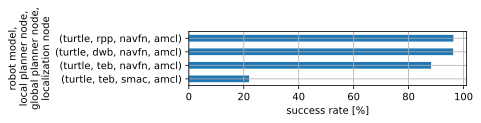

## collision_rate

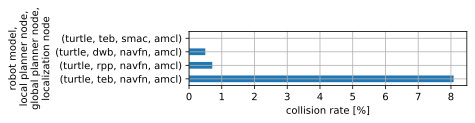

## average_velocity, only successful runs

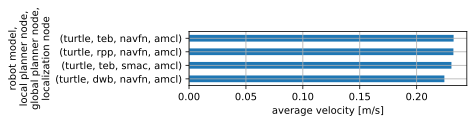

## norm_trajectory_length, only successful runs

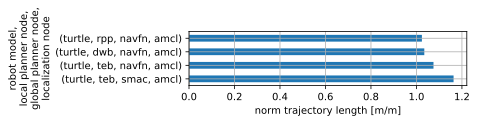

## norm_execution_time, only successful runs

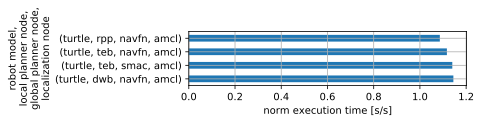

In [10]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner_node', 'global_planner_node', 'localization_node'], percentage=False, unit_symbol=None, higher_better=True):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([5, 1])
    plt.show()
printmd("## success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%')
printmd("## collision_rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%')
printmd("## average_velocity, only successful runs")
bar_plot(metric_name='average_velocity', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m/s')
printmd("## norm_trajectory_length, only successful runs")
bar_plot(metric_name='norm_trajectory_length', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m/m')
printmd("## norm_execution_time, only successful runs")
bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s')

In [11]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


## Localization perf from system features

### absolute translation error

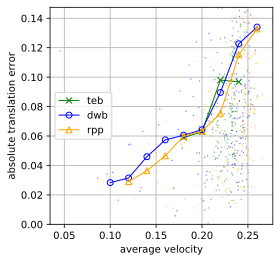

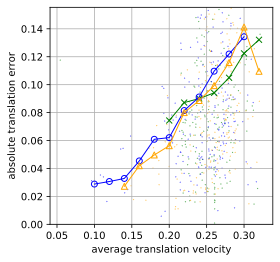

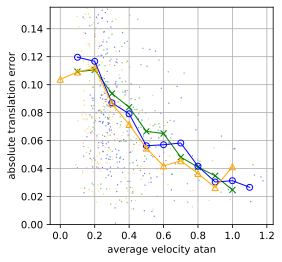

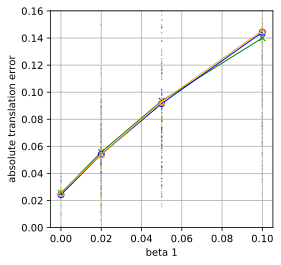

### absolute rotation error

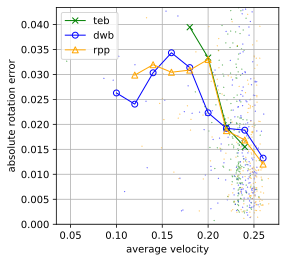

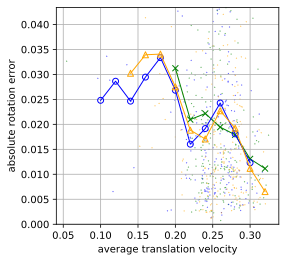

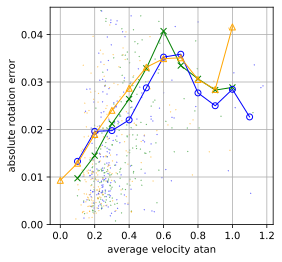

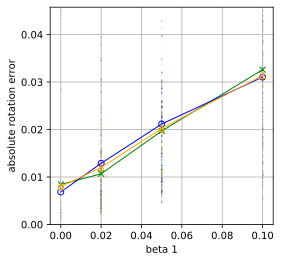

### normalized relative translation error

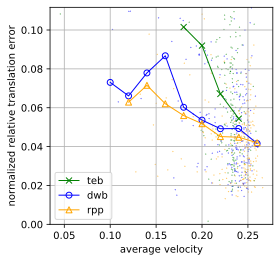

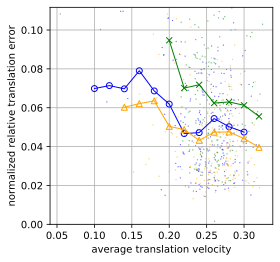

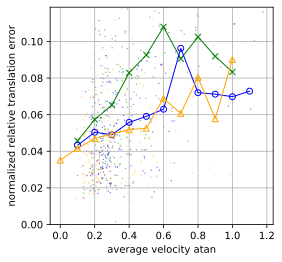

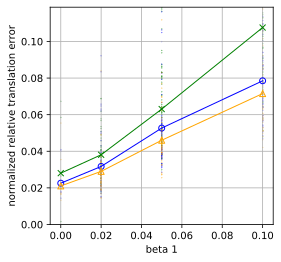

### normalized relative rotation error

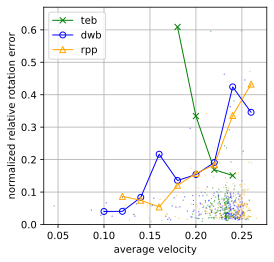

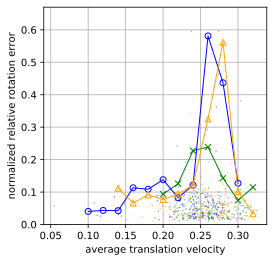

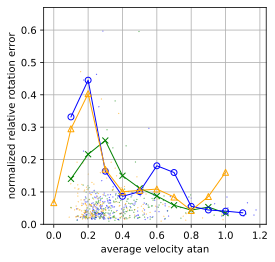

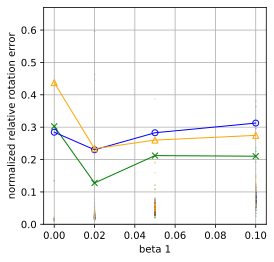

## Localization perf from own parameters

### absolute translation error

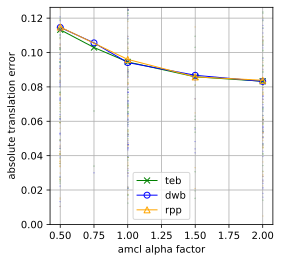

### absolute rotation error

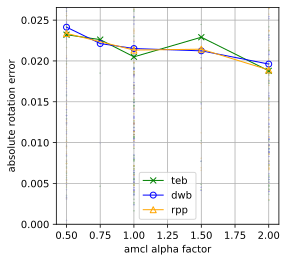

### normalized relative translation error

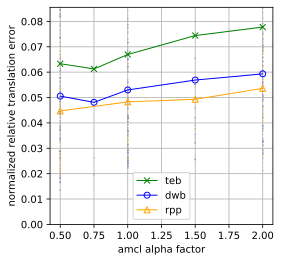

### normalized relative rotation error

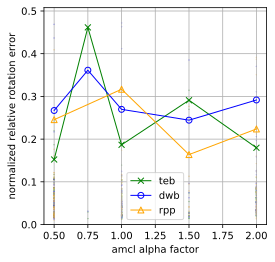

In [12]:
printmd("## Localization perf from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.average_velocity, 0.02], 
    [d.average_translation_velocity, 0.02], 
    [d.average_velocity_atan, 0.1],
    [d.beta_1, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )


printmd("## Localization perf from own parameters")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.amcl_alpha_factor, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )

In [13]:
# printmd("## avg vel and avg vel atan are similar")
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics = [
#     d.average_translation_velocity,
#     d.average_rotation_velocity,
#     d.average_velocity_atan,
# ]
# bin_widths = [0.02, 0.05, 0.1]
# min_bin_count = 10
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_translation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_rotation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity_atan, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )

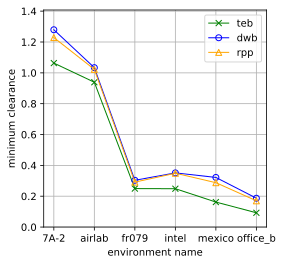

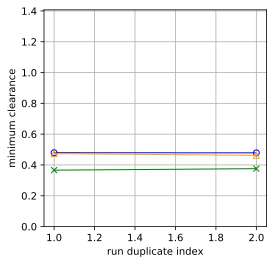

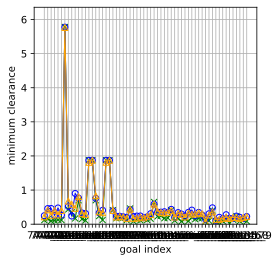

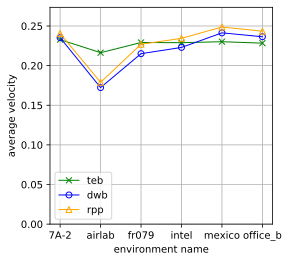

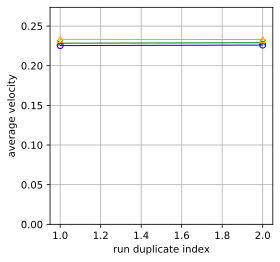

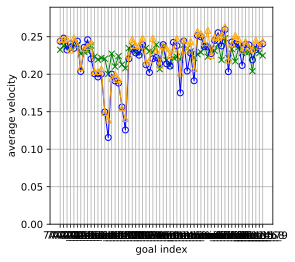

In [22]:

# print(df.goal_index)

bin_widths = [None, None, None]
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics = [
    d.environment_name,
    d.run_duplicate_index,
    d.goal_index,
]

plot_in_out_metrics_bin_width_save(
    output_metric=d.minimum_clearance, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)

In [15]:

# printmd("### norm trajectory length ← absolute translation error doesn't work because when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.01]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.absolute_translation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
    
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [16]:

# printmd("### norm trajectory length, trajectory length ← other localization error metrics")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.03]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.normalized_relative_rotation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


## airlab

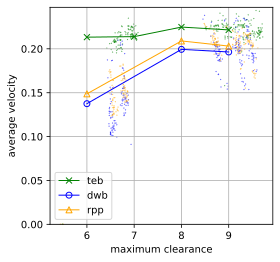

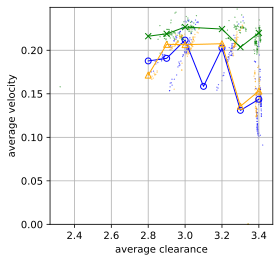

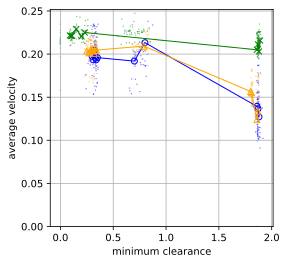

## intel

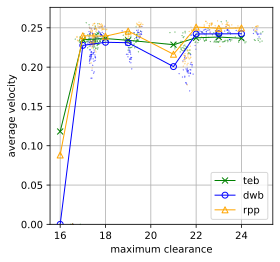

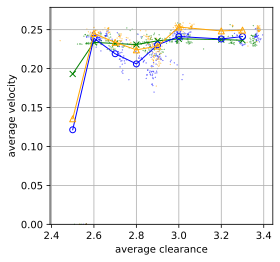

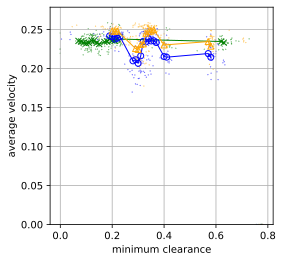

## 7A-2

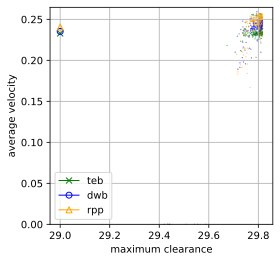

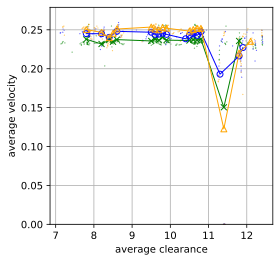

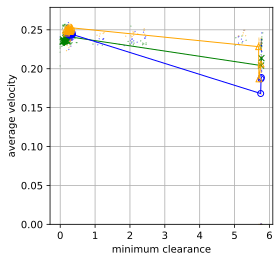

## mexico

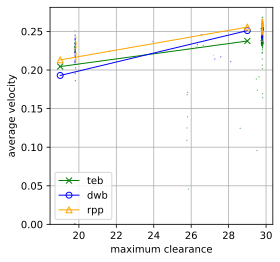

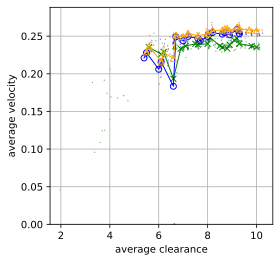

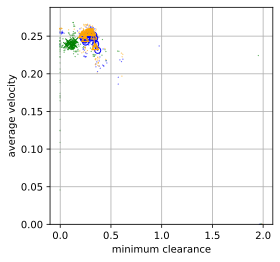

## office_b

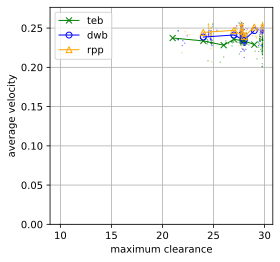

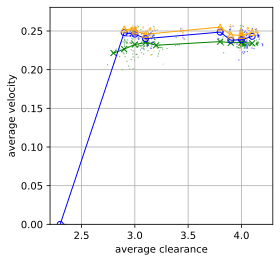

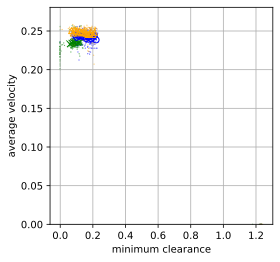

## fr079

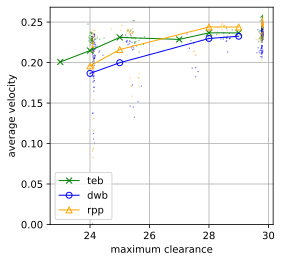

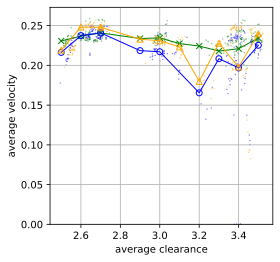

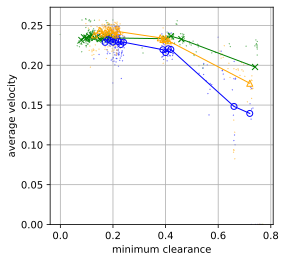

In [17]:


for e in df.environment_name.unique():
    printmd(f"## {e}")
    min_bin_count = 10
    d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
    bin_widths = [1, .1, .01]
    input_metrics = [
        d.maximum_clearance, 
        d.average_clearance, 
        d.minimum_clearance, 
    ]
    plot_in_out_metrics_bin_width_save(
        output_metric=d.average_velocity, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=True,
        out_dir=f"thesis_plots/local_planner/{e}",
    )


## Local Planning perf (also system features)

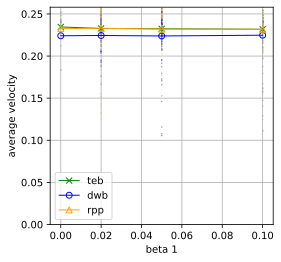

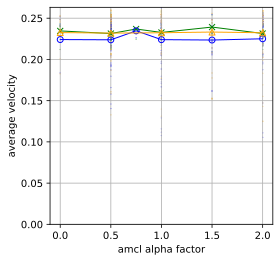

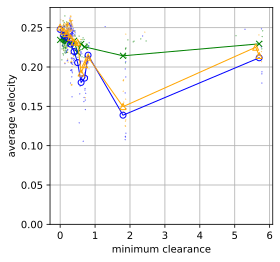

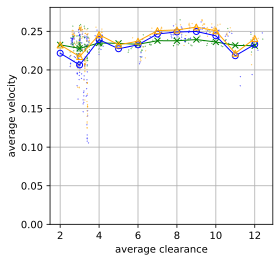

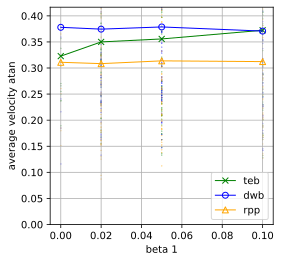

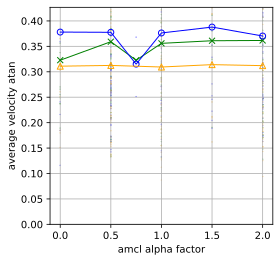

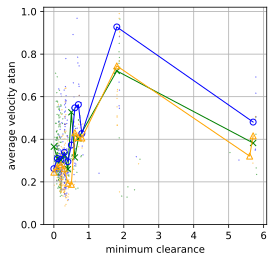

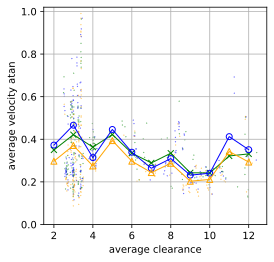

In [18]:

printmd("## Local Planning perf (also system features)")

min_bin_count = 10
d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity_atan, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)

## Local Planning perf (not system features)

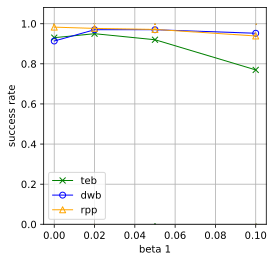

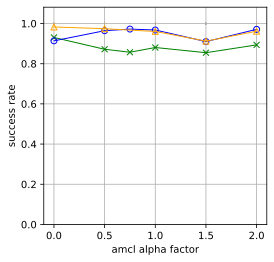

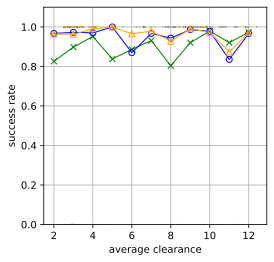

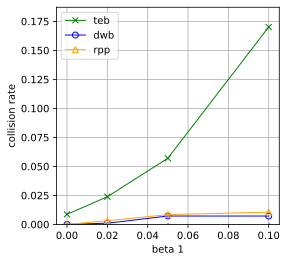

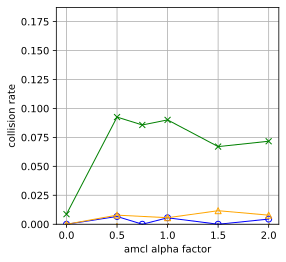

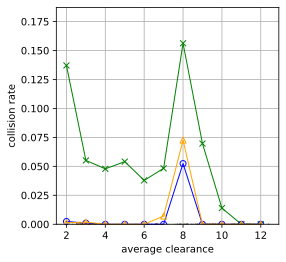

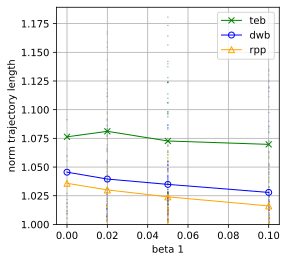

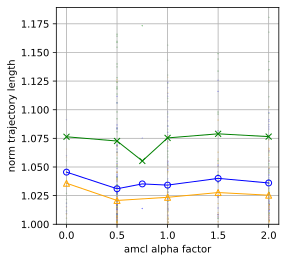

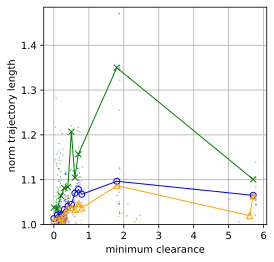

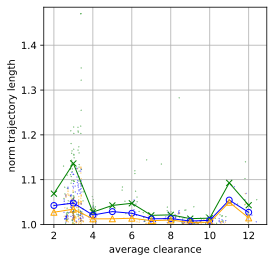

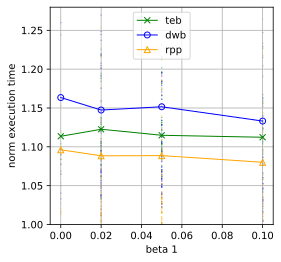

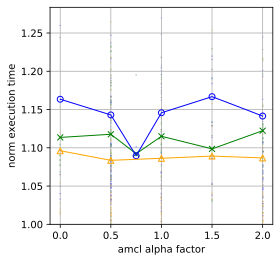

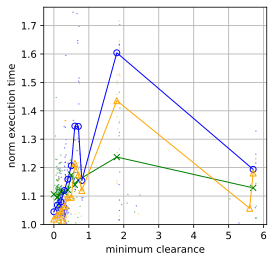

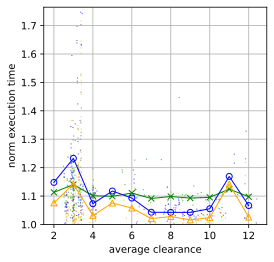

In [19]:
## plots_local_planner

printmd("## Local Planning perf (not system features)")

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collision_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_trajectory_length, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_execution_time, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)

In [20]:
# ## plots_local_planner

# min_bin_count = 10

# d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics, bin_widths = zip(*[
# #     [d.beta_1, None], 
# #     [d.amcl_alpha_factor, None],
# #     [d.minimum_clearance, .1],
# #     [d.average_clearance, 1],
#     [d.absolute_translation_error, 0.05],
#     [d.absolute_rotation_error, 0.01],
#     [d.normalized_relative_translation_error, 0.05],
#     [d.normalized_relative_rotation_error, 0.05],
# ])

# printmd("## norm_trajectory_length")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_std")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_std, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_mean")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_mean, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_median")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_median, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )

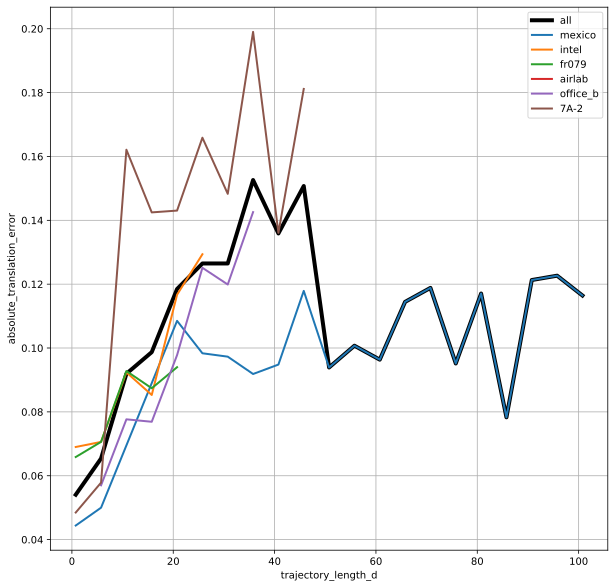

In [21]:
df_s = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()

bins = np.arange(df_s.trajectory_length.min(), df_s.trajectory_length.max(), 5)
df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('absolute_translation_error')
plt.legend()
plt.grid()
plt.show()